## クレジットカードの債務不履行についてのデータセット

データの取得
- Rによる統計的学習入門, 朝倉書店, 2018.<br>
An Introduction to Statistical Learning with Applications in R, Springer, 2017.<br>
http://faculty.marshall.usc.edu/gareth-james/ISL/index.html<br>
https://cran.r-project.org/web/packages/ISLR/index.html

データの説明
- default :	クレジットカードの債務不履行
- student : 	学生
- balance : 	クレジットカードの債務残高
- income : 	年収

内容を確認<br>
- "default","student","balance","income"

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

default = pd.read_csv('data/Default.csv')
# 列ごとの欠損値の数
default.isna().sum()

default    0
student    0
balance    0
income     0
dtype: int64

In [2]:
# データの確認
default.head(2)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700


- default :	クレジットカードの債務不履行
- student : 	学生
- balance : 	クレジットカードの債務残高
- income : 	年収

In [3]:
default.groupby('default').size()

default
No     9667
Yes     333
dtype: int64

In [4]:
# default, student のダミー変数化
df = pd.get_dummies(data=default, drop_first=True)
# データの確認
df.head(2)

,balance,income,default_Yes,student_Yes
0,729.526495,44361.625074,0,0
1,817.180407,12106.134700,0,1


default が Yes の時に 1, student も Yes の時に 1　となるようにダミー変数化されている。

In [5]:
# ダミー変数化された default_Yes の確認
df.groupby('default_Yes').size()

default_Yes
0    9667
1     333
dtype: int64

ダミー変数化する前(Yes/No)後(1/0)で同じ数になっている。

<hr>

### データを眺める

<AxesSubplot:xlabel='balance', ylabel='income'>

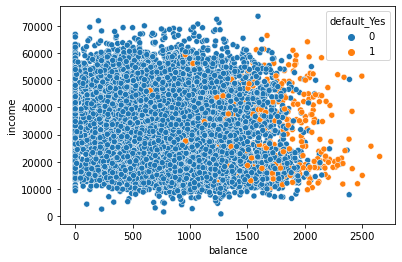

In [6]:
# 散布図
# - 債務不履行 (default_Yes==1) の方がかなり少ない（約3%）のため、傾向が見にくい
sns.scatterplot(x=df.balance, y=df.income, hue=df.default_Yes)

<AxesSubplot:xlabel='balance', ylabel='income'>

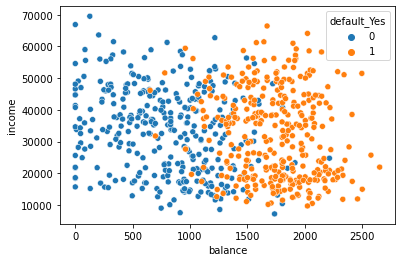

In [7]:
# 散布図
# - 債務不履行 Yes/No を同数にして、傾向をみやすくする
df_plot = df.query('default_Yes==0').sample(n=df.groupby('default_Yes').size()[1])
df_plot = df_plot.append(df.query('default_Yes==1'))
sns.scatterplot(x=df_plot.balance, y=df_plot.income, hue=df_plot.default_Yes)

上記の散布図からは、債務不履行になる人はY軸 (income) 方向には散らばっているが、X軸 (balance) 方向には偏りがあり、債務不履行になる人は債務残高が多い傾向にあるように見える

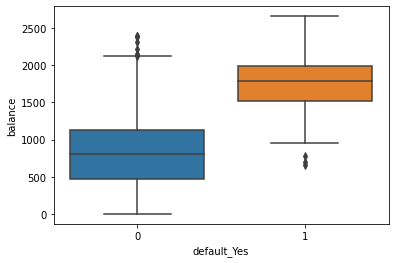

<AxesSubplot:xlabel='default_Yes', ylabel='income'>

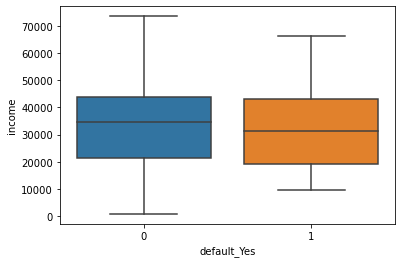

In [8]:
# ボックスプロット
# - Y軸を balance, income のそれぞれで描画し、分布を比較
sns.boxplot(x=df.default_Yes, y=df.balance)
plt.show()
sns.boxplot(x=df.default_Yes, y=df.income)

上のボックスプロットからは、散布図と同様に、債務残高 (balance) が高い人が債務不履行になりやすい関係にあるように見える一方で、年収 (income) とはあまり関係ないように見える。

<hr>

### ロジスティック回帰モデルの作成

balance から default_Yes を予測。

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# 散布図にシグモイド曲線を重ねて表示
def sigmoid(x, b0, b1):
    return 1/(1 + np.exp(-(b0 + b1 * x)))

def Logistic_Model(X, Y):
    """
    ロジスティック回帰モデルを作成
    """
    model = LogisticRegression(C=10000.0)
    model.fit(X, Y)
    return model

def Logistic_Plot(model, X, Y):
    # 散布図
    sns.scatterplot(x=X.iloc[:,0], y=Y)

    # パラメータ
    b0 = model.intercept_[0]
    b1 = model.coef_[0][0]

    # y=0.5となる分割線
    boundary = -b0 / b1
    plt.plot([boundary, boundary], [0, 1], color='lightblue')

    # シグモイド曲線
    _max = X.iloc[:,0].max()
    _min = X.iloc[:,0].min()
    _step = (_max - _min) / 100
    _X = np.arange(_min, _max + _step, _step)
    plt.plot(_X, sigmoid(_X, b0, b1), color='brown')
    
    return boundary

def calc_AUC(model, X, Y):
    """
    AUCの算出
    """
    Y_proba = model.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
    return auc(fpr, tpr)

AUC=0.948
Boundary=1937


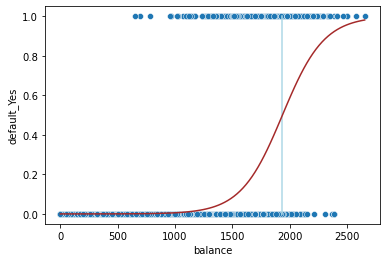

In [10]:
# 説明変数、目的変数を作成
X = df[['balance']]
Y = df.default_Yes

model = Logistic_Model(X, Y)
boundary = Logistic_Plot(model, X, Y)
print('AUC={:.3f}'.format(calc_AUC(model, X, Y)))
print('Boundary={:.0f}'.format(boundary))

### ロジスティック回帰モデルを用いた予測

In [11]:
b0 = model.intercept_[0]
b1 = model.coef_[0][0]
print('b0={}, b1={}'.format(b0, b1))

# balance = $1000, 1500, 2000, 2500 の時の債務不履行となる確率
for balance in [1000, 1500, 2000, 2500]:
    print('${}: {}'.format(balance, sigmoid(balance, b0, b1)))

b0=-10.651328666403131, b1=0.005498915814230607
$1000: 0.005752149837088301
$1500: 0.08294764452205726
$2000: 0.5857693002427882
$2500: 0.9567258270608182


債務残高が $1000の時は債務不履行となる確率は非常に低いが、1500 を超えてからは急に確率は高くなっていく。

In [12]:
# predict_proba(): 予測された確率
# - 引数: 2次元配列（複数の説明変数の列）
# - 戻り値: 2次元配列（各列に対応した 0: y=0 となる確率, 1: y=1 となる確率
for balance in [1000, 1500, 2000, 2500]:
    print('${}: {}'.format(balance, model.predict_proba([[balance]])[0][1]))

$1000: 0.005752149837088301
$1500: 0.08294764452205726
$2000: 0.5857693002427882
$2500: 0.9567258270608182


<hr>

### ダミー変数を説明変数としたモデル

In [13]:
# 説明変数、目的変数を作成
X = df[['student_Yes']]
Y = df.default_Yes

model = Logistic_Model(X, Y)
b0 = model.intercept_[0]
b1 = model.coef_[0][0]
print('b0={}, b1={}'.format(b0, b1))
for student in [0, 1]:
    print('student={}: {}'.format(student, model.predict_proba([[student]])[0][1]))

b0=-3.5041289013227352, b1=0.4048914375165312
student=0: 0.029194979059673085
student=1: 0.043138719772159155


回帰係数 β_1 は正であり、予測値からも、学生の方が債務不履行となる確率が高い。

<hr>

### 複数の説明変数を用いるロジスティック回帰

In [14]:
# 説明変数、目的変数を作成
Y_label = 'default_Yes'
X = df.drop([Y_label], axis=1)
Y = df[Y_label]

model = Logistic_Model(X, Y)
print('AUC={:.3f}'.format(calc_AUC(model, X, Y)))

AUC=0.908


In [15]:
pd.DataFrame(model.coef_[0].reshape(1, 3), index=['係数'], columns=X.columns)

,balance,income,student_Yes
係数,0.004163,-0.000135,-3.979838


student_Yes のみを説明変数とした時には、係数は正で、学生の方が債務不履行となる確率が高い、という結果だったにも関わらず、他の説明変数と合わせて複数の説明変数を用いた場合は、student_Yes の係数は負になっており、学生の方が債務不履行となる確率が低いという結果になった。

In [16]:
# 学生ではない人が債務不履行となった割合
_X0 = df.query('student_Yes==0').groupby('default_Yes').size()
_P0 = _X0[1] / (_X0[0] + _X0[1])
# 学生が債務不履行となった割合
_X1 = df.query('student_Yes==1').groupby('default_Yes').size()
_P1 = _X1[1] / (_X1[0] + _X1[1])
print('一般: {:.3f}, 学生: {:.3f}'.format(_P0, _P1))

一般: 0.029, 学生: 0.043


student_Yes のみを説明変数とした時には、係数は正で、学生の方が債務不履行となる確率が高いという結果がでたとおり、学生が債務不履行となった割合の方が多い。

<AxesSubplot:xlabel='student_Yes', ylabel='balance'>

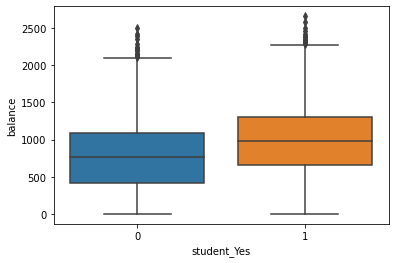

In [17]:
# 学生であるかどうかと債務残高の関係
sns.boxplot(x=df.student_Yes, y=df.balance)

また、学生であるかどうかと債務残高の関係を見ると、学生の方が債務残高が多い傾向にあり、債務残高が多さと学生であることに相関があることになり、多重共線性が疑われる。

これらのことを合わせて考えると、balance, income を固定した場合には、学生である方が債務不履行となる確率は低いことになるが、実際には学生の方が債務残高が多いことから、学生の方が高い確率で債務不履行となる、と解釈することができる。